In [1]:
from bs4 import BeautifulSoup
import urllib.request as req
import re
import pandas as pd

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from time import sleep

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [5]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## 00. Variables

In [7]:
# variables for crawling process
targetCnt = 1000

In [8]:
# variables to store App's general info 
app_titles = []
app_categories = []
app_developers = []
app_ratings = []
app_reviewCnts = []
app_lastUpdates = []
app_downloads = []

In [9]:
# variables to store crawled data
names = [] 
dates = []
ratings = []
upVotes = []
comments = []

In [10]:
# variable with target urls 
urls = ['https://play.google.com/store/apps/details?id=us.zoom.videomeetings',
        'https://play.google.com/store/apps/details?id=com.microsoft.teams']

## 01. Data Crawling

In [11]:
# Chrome Setup
options = webdriver.ChromeOptions()
options.add_experimental_option("prefs", {'intl.accept_languates': 'en,en_US'})
driver = webdriver.Chrome(options = options)

In [12]:
# scrap basic app infos 
def crawl_basicInfo():
    doc = BeautifulSoup(driver.page_source, "html.parser")

    app_titles.append(doc.find(class_ = "AHFaub").text)
    app_categories.append(doc.find_all(class_ = "hrTbp R8zArc")[0].text)
    app_developers.append(doc.find_all(class_ = "hrTbp R8zArc")[1].text)
    app_ratings.append(float(doc.find(class_ = "BHMmbe").text))
    app_reviewCnts.append(int(doc.find(class_ = "AYi5wd TBRnV").text.replace(",", "")))
    app_lastUpdates.append(doc.find_all(class_ = "htlgb")[0].text)
    app_downloads.append(doc.find_all(class_ = "htlgb")[4].text)

In [13]:
# Read more reviews
def click_readMore():
    driver.find_element_by_xpath('//*[@id="fcxH9b"]/div[4]/c-wiz/div/div[2]/div/div/main/div/div[1]/div[6]/div').click()

In [14]:
# Load target amount of reviews
def load_reviews():
    currCnt = 0
    while currCnt < targetCnt:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        driver.find_element_by_tag_name("body").send_keys(Keys.PAGE_UP)
        sleep(2)

        currCnt = len(driver.find_elements_by_class_name("X43Kjb"))

        try: 
            driver.find_element_by_xpath("//*[@id='fcxH9b']/div[4]/c-wiz[2]/div/div[2]/div/div/main/div/div[1]/div[2]/div[2]/div").click()
        except NoSuchElementException:
            pass

In [15]:
# Click all 'Full Review' Buttons
def click_fullReviews():
    fullBtn = driver.find_elements_by_xpath("//button[@jsaction='click:TiglPc']")

    for btn in fullBtn:
        driver.execute_script("arguments[0].click();", btn)

In [16]:
# Crawl review datas 
def crawl_reviews():
    doc = BeautifulSoup(driver.page_source, "html.parser")

    n = doc.find_all(class_ = "X43Kjb")
    names.extend([temp.text for temp in n[4:targetCnt+4]])

    d = doc.find_all(class_ = "p2TkOb")
    dates.extend([temp.text for temp in d[4:targetCnt+4]])

    r = driver.find_elements_by_xpath("//span[@class='nt2C1d']/div[@class='pf5lIe']/div[@role='img']")
    for temp in r[4:targetCnt+4]:
        ratings.append(int(re.findall('\d', temp.get_attribute('aria-label'))[0]))

    uv = doc.find_all(class_ = "jUL89d y92BAb")
    upVotes.extend([int(temp.text) for temp in uv[4:targetCnt+4]])

    lc = driver.find_elements_by_xpath("//span[contains(@jsname, 'fbQN7e')]")
    sc = driver.find_elements_by_xpath("//span[contains(@jsname, 'bN97Pc')]")
    
    del lc[0:4]
    del sc[0:4]
    
    comments.extend([t.text if t.text != '' else lc[i].text for i, t in enumerate(sc[0:targetCnt])])

In [17]:
# Start crawling with pre-defined functions
for i in range(0, 2):
    driver.get(urls[i])
    crawl_basicInfo()
    click_readMore()
    load_reviews()
    click_fullReviews()
    crawl_reviews()

In [18]:
# DataFrame with ZOOM and Teams' overview information
df_overview = pd.DataFrame({"Title":app_titles,
                            "Category":app_categories,
                            "Developer":app_developers,
                            "Rating":app_ratings,
                            "# of Reviews":app_reviewCnts,
                            "# of Downloads":app_downloads,
                            "Last Update":app_lastUpdates})

In [19]:
df_overview

,Title,Category,Developer,Rating,# of Reviews,# of Downloads,Last Update
0,ZOOM Cloud Meetings,zoom.us,Business,3.9,2458790,"500,000,000+","May 25, 2021"
1,Microsoft Teams,Microsoft Corporation,Business,4.1,3439984,"100,000,000+","June 2, 2021"


In [20]:
# Seperate DataFrames for user reviews of  ZOOM and Teams
doubleCnt = targetCnt * 2;

In [21]:
df_zoom = pd.DataFrame({"Reviewer":names[0:targetCnt],
                          "Date":dates[0:targetCnt],
                          "Rating":ratings[0:targetCnt],
                          "UpVote":upVotes[0:targetCnt],
                          "Comment":comments[0:targetCnt]})

In [22]:
df_teams = pd.DataFrame({"Reviewer":names[targetCnt:doubleCnt],
                          "Date":dates[targetCnt:doubleCnt],
                          "Rating":ratings[targetCnt:doubleCnt],
                          "UpVote":upVotes[targetCnt:doubleCnt],
                          "Comment":comments[targetCnt:doubleCnt]})

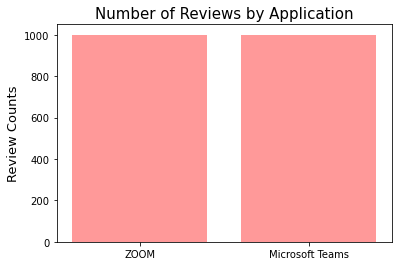

In [23]:
plt.bar(['ZOOM', 'Microsoft Teams'], [len(df_zoom.index), len(df_teams.index)], color='Red', alpha=0.4)
plt.title("Number of Reviews by Application", fontsize=15)
plt.ylabel('Review Counts', fontsize=13)
plt.show()

## 02. Sentiment Analysis

In [24]:
vader = SentimentIntensityAnalyzer()

In [25]:
comments_token = []
for c in comments:
    c1 = word_tokenize(c)
    c2 = [w for w in c1 if w.isalpha()]
    c3 = " ".join(c2)
    comments_token.append(c3)

In [26]:
sentiments = [vader.polarity_scores(comments_token[n])["compound"] for n in range(0, len(comments))]

In [27]:
df_zoom["Sentiment"] = sentiments[0:targetCnt]
df_teams["Sentiment"] = sentiments[targetCnt:doubleCnt]

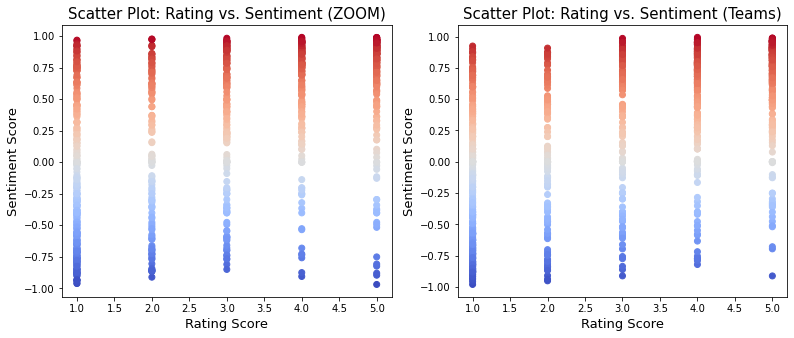

In [28]:
plt.figure(figsize=(13, 5))

plt.subplot(121)
plt.title("Scatter Plot: Rating vs. Sentiment (ZOOM)", fontsize=15)
plt.scatter(df_zoom["Rating"], df_zoom["Sentiment"], c=df_zoom["Sentiment"], cmap="coolwarm")
plt.xlabel("Rating Score", fontsize=13)
plt.ylabel("Sentiment Score", fontsize=13)

plt.subplot(122)
plt.title("Scatter Plot: Rating vs. Sentiment (Teams)", fontsize=15)
plt.scatter(df_teams["Rating"], df_teams["Sentiment"], c=df_teams["Sentiment"], cmap="coolwarm")
plt.xlabel("Rating Score", fontsize=13)
plt.ylabel("Sentiment Score", fontsize=13)
plt.show()

* **As seen above, Rating Scores DOES NOT CORRESPOND to the Sentiment Scores**   
* **Therefore, we'll only use 'Rating' as the criterion for positive/negative review categorization**

## 02. Preprocessing 

* **'Ratings below or above 3' -> 'negative or postive review groups'.**
* **Only use reviews with 'UpVotes >= 5' to sort out less significant ones.**

In [52]:
df_zoom_pos = df_zoom.loc[(df_zoom['UpVote']>=5) & (df_zoom['Rating']>3)]
df_teams_pos = df_teams.loc[(df_teams['UpVote']>=5) & (df_teams['Rating']>3)]
df_zoom_neg = df_zoom.loc[(df_zoom['UpVote']>=5) & (df_zoom['Rating']<3)]
df_teams_neg = df_teams.loc[(df_teams['UpVote']>=5) & (df_teams['Rating']<3)]

In [55]:
comment_category = ["Zoom_Positive", "Teams_Positive", "Zoom_Negative", "Teams_Negative"]
comment_groupCnt = [len(df_zoom_pos.index), len(df_teams_pos.index), len(df_zoom_neg.index), len(df_teams_neg.index)]

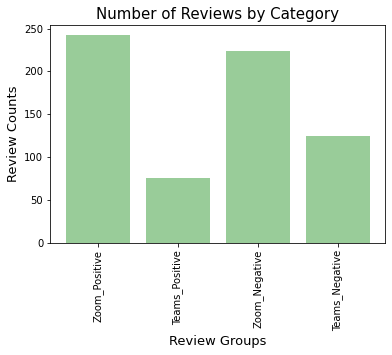

In [56]:
plt.bar(comment_category, comment_groupCnt, color='Green', alpha=0.4)
plt.title("Number of Reviews by Category", fontsize=15)
plt.xlabel('Review Groups', fontsize=13)
plt.xticks(comment_category, fontsize=10, rotation=90)
plt.ylabel('Review Counts', fontsize=13)
plt.show()

In [187]:
sklearn_stopwords = text.ENGLISH_STOP_WORDS
zoom_stopwords = {'zoom', 'app', 'just', 'like', 'apps', 'thing', 'make', "use", "know", "recommend", "experience", "able", "possible",
                'want', 'good', 'times', 'keka', 've', 'take', 'really', 'try', 'meeting', 'work', 'option', 'feature', 'use', 'people'}
teams_stopwords = {'teams', 'app', 'just', 'like', 'apps', 'thing', 'make', "use", "know", "recommend", "experience", "able", "possible",
                    'want', 'good', 'star', 'microsoft', 'take', 'gets', 'times', 'have', 'get', 've', 'take', 'lot', 'try', 'meeting', 
                    'work', 'option', 'feature', 'use', 'people', 'issue', 'day', 'really', 'use', 'using'}
zoom_new_stopwords = sklearn_stopwords.union(zoom_stopwords)
teams_new_stopwords = sklearn_stopwords.union(teams_stopwords)

* **For pre-processing, we'll use 'TF-IDF Vectorizer' & 'Lemmatisation'. Since we are mainly using clustering for analysis.** 

In [188]:
tfidf1_zoom = TfidfVectorizer(lowercase=True, stop_words=zoom_new_stopwords).build_analyzer()
tfidf1_teams = TfidfVectorizer(lowercase=True, stop_words=teams_new_stopwords).build_analyzer()
lem = WordNetLemmatizer()

In [189]:
def get_pos(w):
    tag = pos_tag([w])[0][1][0].upper()
    tag_dict = {"J":wordnet.ADJ,
                "N":wordnet.NOUN,
                "V":wordnet.VERB,
                "R":wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [190]:
def lemmatizer_zoom(x):
    return (lem.lemmatize(w, get_pos(w)) for w in tfidf1_zoom(x))

def lemmatizer_teams(x):
    return (lem.lemmatize(w, get_pos(w)) for w in tfidf1_teams(x))

In [191]:
tfidf2_zoom = TfidfVectorizer(analyzer=lemmatizer_zoom)
tfidf2_teams = TfidfVectorizer(analyzer=lemmatizer_teams)

In [192]:
tfidf_comments_zoom_pos = tfidf2_zoom.fit_transform(df_zoom_pos["Comment"])
tfidf_terms_zoom_pos = tfidf2_zoom.get_feature_names()
tfidf_comments_teams_pos = tfidf2_teams.fit_transform(df_teams_pos["Comment"])
tfidf_terms_teams_pos = tfidf2_teams.get_feature_names()

tfidf_comments_zoom_neg = tfidf2_zoom.fit_transform(df_zoom_neg["Comment"])
tfidf_terms_zoom_neg = tfidf2_zoom.get_feature_names()
tfidf_comments_teams_neg = tfidf2_teams.fit_transform(df_teams_neg["Comment"])
tfidf_terms_teams_neg = tfidf2_teams.get_feature_names()

In [193]:
comment_vector_zoom_pos = pd.DataFrame(tfidf_comments_zoom_pos.toarray(), columns=tfidf_terms_zoom_pos)
comment_vector_zoom_pos.index = df_zoom_pos["Comment"]
comment_vector_teams_pos = pd.DataFrame(tfidf_comments_teams_pos.toarray(), columns=tfidf_terms_teams_pos)
comment_vector_teams_pos.index = df_teams_pos["Comment"]

comment_vector_zoom_neg = pd.DataFrame(tfidf_comments_zoom_neg.toarray(), columns=tfidf_terms_zoom_neg)
comment_vector_zoom_neg.index = df_zoom_neg["Comment"]
comment_vector_teams_neg = pd.DataFrame(tfidf_comments_teams_neg.toarray(), columns=tfidf_terms_teams_neg)
comment_vector_teams_neg.index = df_teams_neg["Comment"]

## 03. Clustering 

* **To decide the number of clusters, we'll try using 'the elbow method'.** 

In [194]:
distance = []

K = range(1, 6)

for x in K:
    km_n = KMeans(n_clusters=x, random_state=0)
    km_fit = km_n.fit(tfidf_comments_zoom_pos)
    num = km_fit.inertia_
    distance.append(num)
    
for x in K:
    km_n = KMeans(n_clusters=x, random_state=0)
    km_fit = km_n.fit(tfidf_comments_teams_pos)
    num = km_fit.inertia_
    distance.append(num)
    
for x in K:
    km_n = KMeans(n_clusters=x, random_state=0)
    km_fit = km_n.fit(tfidf_comments_zoom_neg)
    num = km_fit.inertia_
    distance.append(num)
    
for x in K:
    km_n = KMeans(n_clusters=x, random_state=0)
    km_fit = km_n.fit(tfidf_comments_teams_neg)
    num = km_fit.inertia_
    distance.append(num)

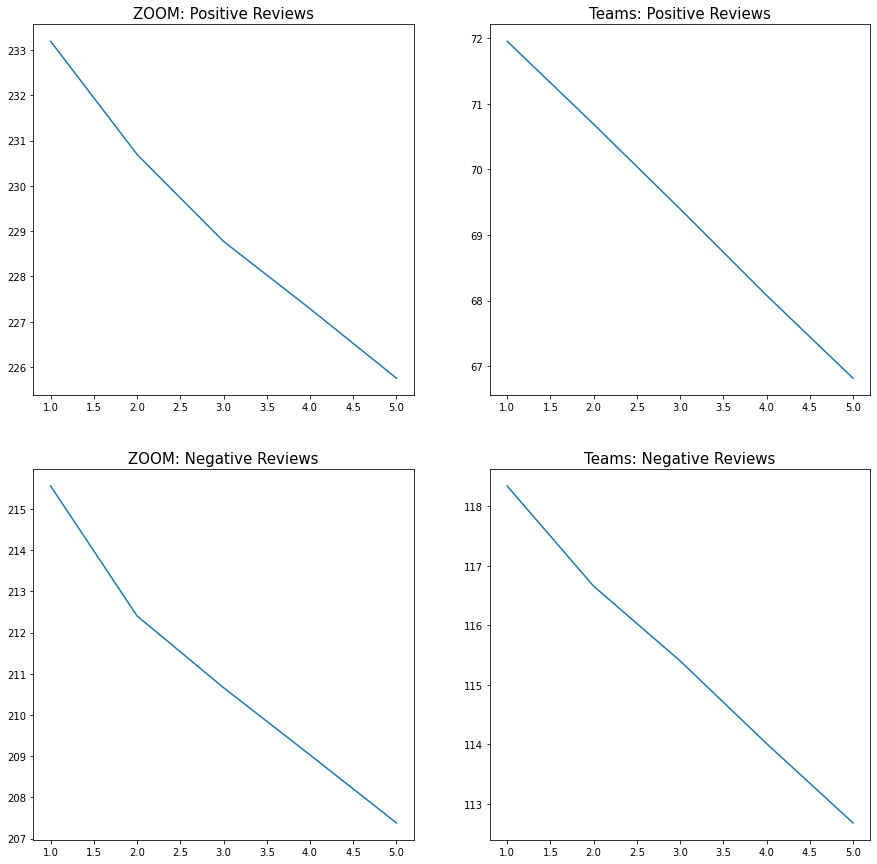

In [195]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.title("ZOOM: Positive Reviews", fontsize=15)
plt.plot(K, distance[0:K[-1]])

plt.subplot(222)
plt.title("Teams: Positive Reviews", fontsize=15)
plt.plot(K, distance[K[-1]:K[-1]*2])

plt.subplot(223)
plt.title("ZOOM: Negative Reviews", fontsize=15)
plt.plot(K, distance[K[-1]*2:K[-1]*3])

plt.subplot(224)
plt.title("Teams: Negative Reviews", fontsize=15)
plt.plot(K, distance[K[-1]*3:K[-1]*4])

plt.show()

* **Unfortunately, there aren't any siginicant 'bumps'.**    
* **However, all four groups share small curves around '4', which is where we'll start.**

In [196]:
clusterCnt = 3

km_zoom_pos = KMeans(n_clusters=clusterCnt, random_state=0)
km_zoom_pos.fit(tfidf_comments_zoom_pos)

km_teams_pos = KMeans(n_clusters=clusterCnt, random_state=0)
km_teams_pos.fit(tfidf_comments_teams_pos)

km_zoom_neg = KMeans(n_clusters=clusterCnt, random_state=0)
km_zoom_neg.fit(tfidf_comments_zoom_neg)

km_teams_neg = KMeans(n_clusters=clusterCnt, random_state=0)
km_teams_neg.fit(tfidf_comments_teams_neg)

KMeans(n_clusters=3, random_state=0)

In [197]:
clusters = km_zoom_pos.labels_.tolist()
df_zoom_pos["Cluster"] = clusters

clusters = km_teams_pos.labels_.tolist()
df_teams_pos["Cluster"] = clusters

clusters = km_zoom_neg.labels_.tolist()
df_zoom_neg["Cluster"] = clusters

clusters = km_teams_neg.labels_.tolist()
df_teams_neg["Cluster"] = clusters

<ipython-input-197-76155d38ca4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_zoom_pos["Cluster"] = clusters
<ipython-input-197-76155d38ca4c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teams_pos["Cluster"] = clusters
<ipython-input-197-76155d38ca4c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

## 04. Most common/relevant words for each cluster

In [198]:
pd.set_option('display.max_colwidth', None)

In [199]:
oc_zoom_pos = km_zoom_pos.cluster_centers_.argsort()[:, ::-1]
oc_teams_pos = km_teams_pos.cluster_centers_.argsort()[:, ::-1]

oc_zoom_neg = km_zoom_neg.cluster_centers_.argsort()[:, ::-1]
oc_teams_neg = km_teams_neg.cluster_centers_.argsort()[:, ::-1]

In [200]:
topWordCnt = 10
topWords_zoom_pos, topWords_teams_pos, topWords_zoom_neg, topWords_teams_neg = [], [], [], []

for i in range(0, clusterCnt):
    topWords_zoom_pos.append([tfidf_terms_zoom_pos[x] for x in oc_zoom_pos[i, :topWordCnt]])
    topWords_teams_pos.append([tfidf_terms_teams_pos[x] for x in oc_teams_pos[i, :topWordCnt]])
    
    topWords_zoom_neg.append([tfidf_terms_zoom_neg[x] for x in oc_zoom_neg[i, :topWordCnt]])
    topWords_teams_neg.append([tfidf_terms_teams_neg[x] for x in oc_teams_neg[i, :topWordCnt]])

* **ZOOM: Positive Reviews**

* Cluster 1: Simple to use. Consistant connection. Easy interface. Great for meetings.
* Cluster 2: Helpful for online classrooms, for both teachers and students. 
* Cluster 3: Poor virtual background support on Android devices.

In [201]:
for i in range(0, clusterCnt):
    print(topWords_zoom_pos[i])
df_zoom_pos[df_zoom_pos["Cluster"] == 2].sort_values('UpVote', ascending=False).head(10)

['meeting', 'great', 'use', 'video', 'easy', 'time', 'way', 'meet', 'connect', 'best']
['class', 'online', 'amaze', 'learn', 'easy', 'meeting', 'helpful', 'teacher', 'student', 'love']
['background', 'screen', 'star', 'problem', 'android', 'nice', 'virtual', 'share', 'phone', 'fix']


,Reviewer,Date,Rating,UpVote,Comment,Sentiment,Cluster
317,Kate Marin,"April 8, 2021",4,1882,"Amazing to interact at such distance. Controls not particularly intuitive (mic, views of others, chat), w resulting frequent hunts for controls & content screen. Prefer a controls option on all screens, visible/not visible by my choice. Also want to be able to choose which screen is always visible, & which/ how many others are next to the always-on screen. Switching to find the current speaker, back to content, etc. really infringes on natural interchange. Glad Zoom exists, tho!",0.8709,2
251,Aryman Pathak 9th 'B',"April 24, 2021",4,1793,"This app is very good. I could have given it a 5-star rating if it not had been for one thing. Whenever we join a meeting on a mobile device, it always asks for our meeting name when we join the meeting and it has started, even after we have entered our name while entering the meeting ID. I request you to pls remove this feature.",0.7841,2
248,Kanishk Saha,"April 23, 2021",5,1534,"Good app. It is very useful more as I really do love this app! It has everything I needed. Just, this needs a update which is loss for you but if you not make the update it is also fine for me. You have made that 3 participants ( including host ) and it ends after 40 minutes. It is annoying and we need to rejoin. Please do fix and make it unlimited. The special feature is not adverts. Thanks for a great app, wishing you a happy day ahead!! THANK YOU FOR A GREAT APP. MY DREAM WAS TO GET THIS APP.",0.9890,2
486,Shital Gavhankar,"April 30, 2021",4,1469,"App is superb no doubt but need to improve there are loop holes being teacher it is difficult some time audio issue some ,and unmute system should be improved with new idea , background should allow from mobile also please I hope app will go further and will fulfill our expectations,I am daily user of this app . request you to change as soon as possible",0.9581,2
0,Anushka K,"May 31, 2021",4,1464,It's a really good app. I do really appreciate it. And would love to recommend it to everyone. Just couldn't give all 5 stars because 2 main features I wanted to use wasn't accessible for me. 1. Virtual background enhancement(I use Redmi note 9). 2. Recording feature(please do consider that not everyone is well equipped with laptops and others facilities so please do allow that features to be used in android phones too. It might be very much useful for teachers like me.),0.9702,2
34,Allana Erispe,"May 28, 2021",5,733,This is a good app for meetings but the only problem is that the virtual background doesn't support all devices. I suggests that the developer/s of this app should improve the virtual background by supporting all version of the devices because not all of the people can afford to buy high end devices.,0.8641,2
186,Matthew McCormac,"May 14, 2021",4,684,"Works great except the following two bugs which drive me mad: 1. I have zoom installed both on my android phone and windows laptop. Once I answer on the windows laptop, the notification continues until I hit decline on the android phone 2. When I make a regular cellular phonecall on my android phone, zoom call notification plays really loud in my ear when I'm on the cellular call.",0.4404,2
282,Davin Lassiter,"April 15, 2021",4,663,"Add some Samsung Dex support so I don't have to switch between mirror mode and desktop mode, and a clearer process with screen sharing, and it would be closer a five-star app; it works so differently than how it does on my desktop (Linux mint 19.1), but now that I've gotten the hang of it it's, actually a better experience than I originally thought.",0.7650,2
313,Val Havard,"April 2, 2021",5,494,"Zoom is Great for our family quizzes when there are 4 devices apart from mine. I miss out with larger gatherings as I can only see up to 4 devices on my tablet's screen, I then decide to see the speaker view. Zoom is Far better than another meeting app I used as you can choose the speaker view, and it's v

* **Teams: Positive Reviews**

* Cluster 1: Useful when working with large groups. 
* Cluster 2: Great synchronization between desktop & mobile. Compatability with office 365 applications. 
* Cluster 3: Continuous authentication issue at login. Unstable quality controls. 

In [206]:
for i in range(0, clusterCnt):
    print(topWords_teams_pos[i])
df_teams_pos[df_teams_pos["Cluster"] == 2].sort_values('UpVote', ascending=False).head(10)

['work', 'love', 'online', 'well', 'group', 'great', 'chat', 'network', 'm', 'time']
['desktop', 'meeting', 'chat', 'call', 'type', 'come', 'application', 'great', 'phone', 'message']
['fix', 'update', 'log', 'upload', 'work', 'thank', 'stop', 'slow', 'try', 'solution']


,Reviewer,Date,Rating,UpVote,Comment,Sentiment,Cluster
73,My Cinema,"May 21, 2021",4,373,"UPDATE Issue has been resolved so have updated from 1 to 4 stars. ------------ Same issue as many other users ... Continuous authentication. I have tried all the ""fixes"" suggested and none work. Microsoft now suggest waiting 60 seconds and the issue will clear. Waited 5 mins and still continuously authenticating. How about this as a suggestion - go back to the last know good version. (Advice offered free of charge!)",0.8591,2
990,Ridam Chaudhary,"May 19, 2021",4,290,"In current version, there is a bug where loading the app causes an endless loop of trying to reauthenticate, resulting in incessant flashing popup on the screen. Clearing the cache, data, and force stopping the app do not resolve the issue. It seems to be on the server end, and it's hit or miss whether I am able to use the app. Please address this issue and then reply to this, and I will update the rating. Thank you, and stay safe! Edit: Updated rating, per fix and reply. Thanks!",0.7364,2
288,Maanvendra Tiwari,"May 28, 2021",4,69,"Fantastic But uploading speed is slow. I know that it depends on internet but if we quit app it stops uploading and disappear from there ( image, file, etc.) If we see WhatsApp, if there also it uploads according to speed but if we quit app it doesn't stop and keeps uploading.",-0.5789,2
82,SS_Grace,"May 30, 2021",5,37,"Update: suddenly works again. Used to work flawlessly. However yesterday I was suddenly logged out from my work account. When I re-signed, I lose the ability to switch tenant and always back to my default tenant no matter which tenant I tapped. Tried clear data and even reinstall to no avail. Selecting ""Report an issue"" only preparing TeamsClientLog.zip in share popup, but whom does I share it to? Hopefully it's fixed ASAP so I can rate it back to 5 stars",0.7783,2
930,Joe McMullin,"May 24, 2021",5,16,"5/12 ... an update to the Microsoft Authenticator app solved this endless loop issue. Teams is now accessible again. Thank you! 5/10 ... still happening!! Oh my. The latest update is slow. It constantly attempts to load what appears to be a login or authorization window. Never stops .. endless loop! Clearing cache and app data or reinstall are the only solutions, but the problem returns within 24 hrs. Please fix .. I need this for work!!!!",0.3120,2
244,Yasashwini,"May 20, 2021",5,11,Amazing software. Has totally revolutionised the way we work. Have been trying for years to persuade our boards to seek a solution like this. It is more inclusive and enables greater diversity as we no longer need to meet in person. We'll done to you all and thank you. Simon Payne,0.8860,2
167,Joshna Jos,"May 31, 2021",5,10,Updated review: It worked after uninstalling and installing again. Previous Review: Unable to login to my account back after updates. Error : Can't downgrade database from version 237 to 223 SQLiteInjection & RuntimeExceptionError on ActivityThread.callActivityOnStop method ActivityThread.java line number 4711 Happens when I am logging into my corporate account.,-0.3400,2
113,Andre Groenendijk,"May 28, 2021",4,9,"Much better, lighter and feature packed option than Skype for Business. Of course, this is a bigger solution with many integrations to Microsoft technologies like SharePoint or Planner. But for conferences and work chat it works much better in Android than S4B. Now, I can't say the same of the Windows app. Lately it is misbehaving with the android keyboard so I have to decrease the rating.",0.7845,2
144,Ahmed' s Videos and Vlogs,"May 27, 2021",5,6,"There is something wrong about the latest update. Signed in successfully but the synchronized process was taking forever that i couldn't use the app. Since i use this app for working purposes, please take a considerably amount of time to fix this. Thank you.",0.7791,2
150,Bill Lampert,"May 19, 2021",4,6,"Every time I don't open the app for a interval of 3-4 days, I am logged out

* **ZOOM: Negative Reviews**

* Cluster 1: Video & Audio lags. Lack of speaker screen grid view on mobile. 
* Cluster 2: Unstable network connection. 
* Cluster 3: Lack of virtual background suppport on many Android devices.

In [209]:
for i in range(0, clusterCnt):
    print(topWords_zoom_neg[i])
df_zoom_neg[df_zoom_neg["Cluster"] == 2].sort_values('UpVote', ascending=False).head(10)

['share', 'join', 'video', 'screen', 'try', 'link', 'account', 'audio', 'use', 'don']
['problem', 'connect', 'network', 'show', 'bad', 'fix', 'class', 'phone', 'time', 'solve']
['background', 'update', 'virtual', 'version', 'work', 'issue', 'user', 'android', 'stop', 'use']


,Reviewer,Date,Rating,UpVote,Comment,Sentiment,Cluster
176,Suzanne Cakalic,"March 27, 2021",2,17289,"In general, don't really have a problem, but more specifically: it eats a LOT of battery. Many times I have to connect my charger just to get through 1½ hour meetings when I started with 100%. After update I can do virtual backgrounds (Yay!). Can't start a meeting of my own, only can join. Can't even find a way to sign out and sign back in again. What's up with that? Updated on another device and no option for virtual backgrounds again. Was able to use them before, but now it does not even show.",0.5590,2
125,UMAR SIDDIQUI,"May 13, 2021",2,7266,"The app works well and without any interruptions. But I'm still unable to use this app with Bluetooth eatphones. This is very serious since new mobile phone are getting rid of the headphone jack and in that case Bluetooth is a must. Whenever I join a meeting with Bluetooth earphones,it works well for 2 minutes and then it starts lagging. Please resolve this issue before it's too late.",0.8345,2
137,Rifqi Zauhair,"May 21, 2021",1,789,"It has the problem during the connection unstable but I'm ensure to use the highly connection speed of WiFi signal. This problem is happened twice. I've already uninstalled for twice and updating the app version. For the moment after the latest version's update, it solved. In my second chance after update, the buggy message of error 5003 is appear again. I hope zoom could resolve this for the user. At least, because zoom is first choice for video teleconferencing. Thanks",0.8735,2
33,Ali Ben Ezzeddine,"May 26, 2021",2,676,I'm on a tablet and when I join my class' zoom it's recorded when I join it a little message pops up and when I do accept it tells me: recording started or something even when I leave like that this even happens to my classmates and also can example do the filters and the video background too because I only know that all of the filters and video backgrounds are used in the iPad and laptop please fix this. -Thank you.,0.8625,2
347,Alexander Bunn,"April 16, 2021",1,581,"Exceedingly poor UI design, ended up having to aplogise and being muted by host in a company wide meeting for joining remotely in an area with a bit of background noise because I was unable to locate the mute control on my end. All I could do was switch between viewing my camera, the active speaker, and all other call participants. In these times it's simply unexcusable for such a vital app like this to have such pathetic UI design.",-0.1027,2
260,Gregas Gregorio,"April 19, 2021",2,574,"This app is very limited compared to what can be done with the desktop version. Unlike the desktop version, the Android app only shows a maximum of 4 participants at once. Even on a large tablet. There is no option to blur the background. The app works ok, but find myself consistently switching to my computer because of something I cannot do in the app.",-0.1522,2
270,Laurel,"April 8, 2021",1,572,"I really wanted to be able to use Virtual Backgrounds with this since I cannot do so on my laptop (even though it has FAR above the minimum requirements to run it...) But, nope, there is not even the option showing to use virtual backgrounds for the app, either. I REALLY need this feature for work...so frustrating that I can't use it on either device.",-0.5777,2
420,ellen blessed,"March 27, 2021",1,213,"Everything is quite good except for one thing, I CAN'T MESSEGE SOMEONE THAT IS NOT A HOST OR CO-HOST! And I cannot move people when a person is spotlighted. This app could just make the spotlighted person pn the very front wile I could move other people near me. This app needs to improve a lot the next update! This app also has many bugs!",0.7264,2
706,Sashan Jayawardena,"May 4, 2021",1,102,"Support for Android 4.4? I have older tab with android 4.4 since latest app only supports only android 5 upwards, I found apk that support for Android 4.4 from a third party site. It normally installs and when joi

* **Teams: Negative Reviews**

* Cluster 1: Error loop on the account authentication page. 
* Cluster 2: Not in sync with the desktop version. 
* Cluster 3: Long load times. File sharing system can be glitchy. 

In [212]:
for i in range(0, clusterCnt):
    print(topWords_teams_neg[i])
df_teams_neg[df_teams_neg["Cluster"] == 2].sort_values('UpVote', ascending=False).head(10)

['work', 'account', 'don', 'message', 'screen', 'phone', 'log', 'reinstall', 'open', 'sign']
['chat', 'update', 'mobile', 'device', 'desktop', 'doesn', 'android', 'notification', 'read', 'organization']
['time', 'take', 'problem', 'video', 'fix', 'share', 'update', 'doesn', 'join', 'load']


,Reviewer,Date,Rating,UpVote,Comment,Sentiment,Cluster
984,Jasmine Leong,"May 22, 2021",1,1436,"The Teams Android app was amazing for so long, it worked flawlessly for me. After this most recent update all it does is refresh the screen and I can't click on anything for 30 seconds to a minute. Then when I try to click on something, it gives a helpful error message: ""Something went wrong."" I can't communicate with this app anymore, I've tried deleting cache for the app, reinstalling, etc and nothing has fixed this. Microsoft, please fix this app.",0.5994,2
146,Josh Price,"May 29, 2021",1,835,"Sometimes, the GUI disappears and the shared screen or gallery is just there, no other response other than pressing the power button. Whenever I switch to another window, the MS Teams become unresponsive to touch but still going on.",-0.1531,2
16,Karen Anne Marzo,"May 20, 2021",1,452,It takes ages to load and even cannot download files. When my internet speed is fast then also it takes ages to open a file and it is very slow. There is lots of problems when I try to navigate from one part to another. While joining meeting also it takes long time to join and when you try to unmute your mic it takes lots of time so I cannot present my views in the meeting. It needs alots of improvements.,0.2023,2
27,Ridhima Sharma,"May 20, 2021",2,443,"Dear Microsoft, I have several issues using this app: 1. The call ends unexpectedly 2. The shared image is sometimes worse than the garbage 3. Audio and video sometimes crashes the application The list continues... I hope that these issues would be patched soon. And as a request, add a feature to manage the timeout. Also I am unable to login on Parrot sec. OS. (Web and application)",0.5859,2
868,Zane Geurtse,"May 19, 2021",1,369,"Absolutely the worst app. Can't connect my Bluetooth headphones during a meeting. Works with all other apps, but not Teams. Fine, try listening through the speaker. With every spoken word, there's static afterward. I'm a frontline worker who doesn't get the luxury of an office. So how am I suppose to maintain privacy when the platform being used doesn't work?",-0.5540,2
40,Andrei Dobrea,"May 21, 2021",1,241,"Absolutely ridiculous that, with so much feedback over the last year or so, the developers have not installed a way to reject incoming calls during quiet hours. I have work partners who are in different time zones and they attempt group calls at 5-6 a.m. my time. I would hate to delete the app, as otherwise it is very good, but I am about to be forced to do that after another unwanted wake up call. Be better!",-0.6705,2
129,Tejas Patil,"May 22, 2021",2,232,"This app is glitchy and crashes constantly, I can't use it to conduct any business activities as I always get a pop up saying 'Something went wrong'. It only serves a purpose by permitting you to check to your diary before the working day. It feels as if the main cooperations focus more on IPhone and forget Andripd optimisation.",-0.3400,2
15,Kaz Z,"June 2, 2021",2,192,"It does work well on pc, but not on the mobile app. Time shift takes a really long time to load, and at times does not load at all. i always have to close the app, put it back on and try to load shifts. I do this not only once, but many times before I actually can time in. i hope you fix this issue. almost all of my workmates experience this.",0.6597,2
32,Microsoft Corporation,"May 20, 2021",1,171,"Absolutely awful I've missed v important meetings. Every time I've used it, and on different devices, it either doesn't work at all or glitches like crazy. Lose audio, video etc. Utterly useless. If I could I'd use Zoom every time which never goes wrong. But unfortunately so many organisations are using this heap of c***. I'd give it zero stars but you can't.",-0.6277,2
889,Ronda Derk,"May 10, 2021",1,162,"I use this app for work. We chat, share pictures and videos taken from the field. Microsoft Teams handles sharing videos really badly. Most of the time videos fail 

In [214]:
df_zoom_pos.loc[df_zoom_pos["Cluster"]==0]

,Reviewer,Date,Rating,UpVote,Comment,Sentiment,Cluster
4,Angela Treasure,"May 30, 2021",5,1084,"Zoom is a blessing, its not perfect, nothing in this world is perfect, God bless the person or persons who invented this app, keep up the good work, there are some kinks that needs to be straightened out, sometimes voice or picture quality could be better. Picture and voice quality much improved, again, thanks for your service.",0.9170,0
7,Yeshwanth Gosukonda,"June 2, 2021",5,7,keka,0.0000,0
8,Bakhrom Norkulov,"May 31, 2021",4,902,"Hi there I am Bakhrom Norkulov, a Software Engineer I want to tell u one thing about ZOOM. From my own experience while using ZOOM, I have a bug during usage. It is all about chatbox. Whenever one line of text is written in the chatbox, if the user wants to continue the line by the second line, it is impossible. When I tried to step to the next line, while pressing ""Enter"" button , it will automatically send the message instead of continuing. I hope u will improve it✌",0.7269,0
18,Tim Clarke,"May 27, 2021",5,1298,"LOVE IT! Using zoom on a mobile device is a super simple and smooth experience. Its by far the best, most reliable tool of its kind that i have used and I can't recommend it highly enough. Thanks to the lovely people at zoom for a great product that just does what it says it will do. a rarity in this day and age.",0.9849,0
19,Rishi Chanardip,"June 1, 2021",5,22,"I absolutely love it, it works wonderfully but it takes long to update, the emoji library takes forever to download and it is very hard to get a profile picture. If zoom was to update again, I suggest to have a ""set profile picture"" option in settings .",0.4866,0
...,...,...,...,...,...,...,...
961,Trish Difranco Difranco,"May 28, 2021",4,45,I like zoom. It's has really taken off for everyone during the pandemic since we are in a virtual situation now. It's not perfect so that's why it doesn't get a 5 stars. But it's a really good way to connect.,0.4009,0
965,Bobby Willingham,"May 14, 2021",5,7,It is a very good app for connecting over with people and we can store a huge amount of data also in the zoom app and it is really a thrilling and a good experience of using zoom .Try downloading it and I am sure that u are also going to like it very much,0.9421,0
971,Kiran Singh,"May 25, 2021",4,12,Zoom is good for online meetings but it happens to use more data bundle and it needs high speed internet connection which is not best for the people at rural areas. Please check out and fix it. Lower the app expectations.,-0.5349,0
975,Tokyo Toki Fnaf,"May 5, 2021",4,6,"Very efficient for meetings when purchased. However you have to rejoin for meetings that are free, last a shorter time.",0.7501,0
